# faceAI

The final Computer Vision project in the [Artificial Intelligence Nanodegree program](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)!

In this project,we’ll combine our knowledge of computer vision techniques and deep learning to **build and end-to-end facial keypoint recognition system!** 


## Setup 

**Part 1** : Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier
* [Step 1](#step1): Add Eye Detection
* [Step 2](#step2): De-noise an Image for Better Face Detection
* [Step 3](#step3): Blur an Image and Perform Edge Detection
* [Step 4](#step4): Automatically Hide the Identity of an Individual

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints
* [Step 6](#step6): Compile and Train the Model
* [Step 7](#step7): Visualize the Loss and Answer Questions

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image!

* [Step 8](#step7): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline)

## History 

![](http://nikhilbuduma.com/img/facial_keypoints.png)

**Facial keypoints** are otable points around the eyes, nose, and mouth on any face and are used in many applications, from facial tracking to emotion recognition.
There are three main parts to this project:

In this project you will get to explore a few of the many computer vision algorithms built into the OpenCV library.  This expansive computer vision library is now [almost 20 years old](https://en.wikipedia.org/wiki/OpenCV#History) and still growing! 

---
<a id='step0'></a>
## Step 0: Detect Faces Using a Haar Cascade Classifier

Have you ever wondered how Facebook automatically tags images with your friends' faces with [DeepFace](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)? Or how high-end cameras automatically find and focus on a certain person's face? 

Applications like these depend heavily on the machine learning task known as *face detection* -  which is the task of automatically finding faces in images containing people.  

At its root face detection is a **classification problem - distinguishing between distinct classes of things.**  With face detection these distinct classes are 1) images of human faces and 2) everything else. 

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades)! 

We have downloaded one of these detectors and stored it in the `detector_architectures` directory.

### Import Resources 

In the next python cell, we load in the required libraries for this section of the project.

In [45]:
# Settings
%matplotlib inline

# Libraries
import numpy as np              # Numpy for array management
import matplotlib.pyplot as plt # Matplotlib for plotting
import math                     # Math for...math?
import cv2                      # OpenCV library for computer vision
from PIL import Image           # Python Image Library to handle i
import time 

Next, we load in and display a test image for performing face detection.

*Note*: by default OpenCV assumes the ordering of our image's color channels are Blue, then Green, then Red (BGR).  This is *slightly* out of order with most image types whose color channels are ordered Red, then Green, then Blue (RGB). 

In order to switch the Blue and Red channels of our test image around we will use OpenCV's ```cvtColor``` function, which you can read more about [here](http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html); but in general, this utility function that can transform it for us, and do other transformations like converting a color image to grayscale, transforming a standard color image to [HSV](https://en.wikipedia.org/wiki/HSL_and_HSV) (Hue, Saturation, Lightness), etc.

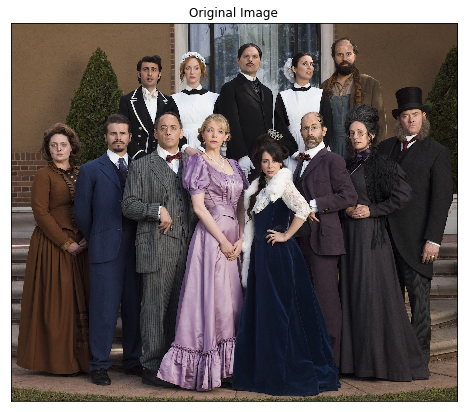

In [46]:
# Load in color image for face detection
image = cv2.imread('images/test_image_1.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

There are a lot of people - and faces - in this picture.  13 faces to be exact!  

In the next code cell, we demonstrate how to use a [Haar Cascade classifier](https://docs.opencv.org/3.3.0/d7/d8b/tutorial_py_face_detection.html) to detect all the faces in this test image.

![](https://docs.opencv.org/3.3.0/haar_features.jpg)

This face detector uses information about patterns of intensity in an image to reliably detect faces under varying light conditions. So, to use this face detector, we'll first convert the image from color to grayscale. 

![](https://docs.opencv.org/3.3.0/haar.png)

But among these features we calculated, most of them are irrelevant. For example, consider the image above. Top row shows two good features:

1) The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. 

2) The second feature selected relies on the property that the eyes are darker than the bridge of the nose.

But the same windows used on cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features?  We brute force it with [Adaboost](https://en.wikipedia.org/wiki/AdaBoost)! 

We save a set of classifiers for each feature (eyes, nose, ears, etc. and make sure it can detect that featureset across images, then run that **cascade of classifiers** and see if we find faces! Here's someone smarter explaining it:

> For this they introduced the concept of Cascade of Classifiers. Instead of applying all the 6000 features on a window, group the features into different stages of classifiers and apply one-by-one. (Normally first few stages will contain very less number of features). If a window fails the first stage, discard it. We don't consider remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is the plan !!!

![](https://docs.opencv.org/3.3.0/face.jpg)

Luckily, these guys even saved a fully trained architecture of the face detector -- found in the file *haarcascade_frontalface_default.xml* - and we can use it on our image to find faces! (To learn more about the parameters of the detector see [this post](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters).)

Number of faces detected: 13


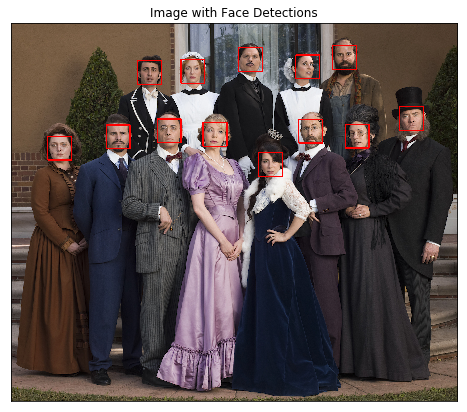

In [47]:
# Convert the RGB  image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
# This Haar Cascade Classifier specializes in frontal face detection!
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image (Define bounding dimensions for the box)
faces = face_cascade.detectMultiScale(gray, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detections')
ax1.imshow(image_with_detections)

In [48]:
print(faces)

[[1295   94   96   96]
 [ 917  103   96   96]
 [1146  132   96   96]
 [ 684  150   96   96]
 [ 510  156   96   96]
 [1565  339   96   96]
 [ 588  390   96   96]
 [1158  391   96   96]
 [ 773  404   96   96]
 [1345  411   96   96]
 [ 383  414   96   96]
 [ 147  459   96   96]
 [ 996  526   96   96]]


In the above code, `faces` is a numpy array, holding  of detected faces! Awesome!

Here each row corresponds to a detected face, where each detected face is a 1D array with four entries that specifies the bounding box of the detected face:
* `x`: The horizontal position of the detection box.
* `y`: The vertical position of the detection box. 
* `w`: The width of the detection box.
* `h`: The height of the detection box. 

If you think this depends a lot on the notion of this 'box', you're right! Shrinking or widening the shape of our bounding box, significanlty impacts our face detection ability. Let's see if we can improve our performance with even more features!

Number of faces detected: 6
Number of faces detected: 10
Number of faces detected: 0


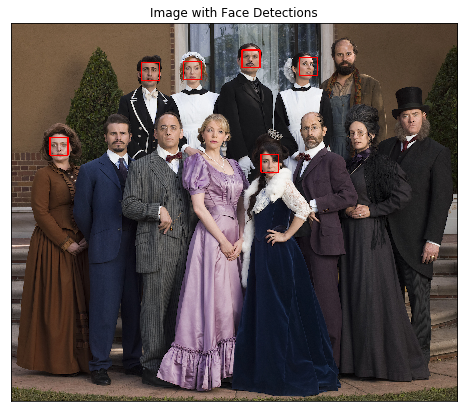

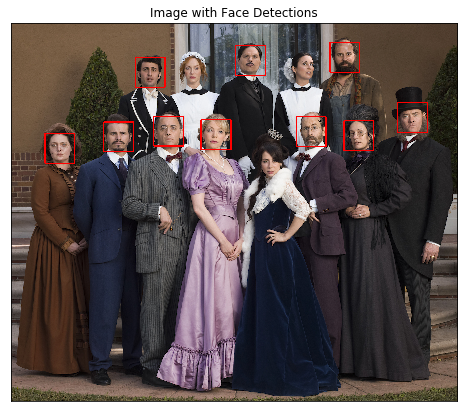

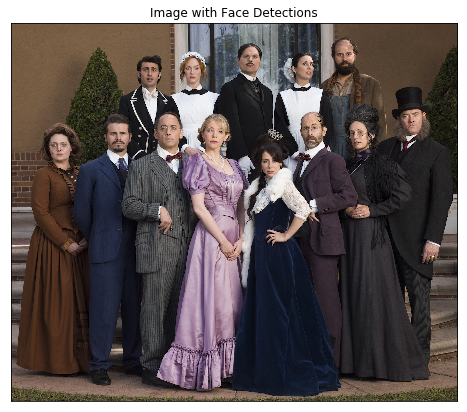

In [49]:
faces_smallbox = face_cascade.detectMultiScale(gray, 3, 3)
faces_mediumbox = face_cascade.detectMultiScale(gray, 5, 5)
faces_bigbox = face_cascade.detectMultiScale(gray, 7, 7)

# Get the bounding box for each detected face
def faceFinder(face_vector): 
    # Print the number of faces detected in the image
    print('Number of faces detected:', len(face_vector))

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)
    
    # Add a red bounding box to the detections image
    [cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3) for (x,y,w,h) in face_vector]

    # Display the image with the detections
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax1.set_title('Image with Face Detections')
    return ax1.imshow(image_with_detections)
    
faceFinder(faces_smallbox)
faceFinder(faces_mediumbox)
faceFinder(faces_bigbox)

---
<a id='step1'></a>

## Step 1: Add Eye Detections

Luckily, there are even more pre-trained detectors available that use a Haar Cascade Classifier - including full human body detectors, license plate detectors, and more! Since this strategy just depends on having cascades of valid classifiers, we can put a ton in a row and detect more!

[A full list of the pre-trained architectures can be found here](https://github.com/opencv/opencv/tree/master/data/haarcascades). 

To test your eye detector, we'll first read in a new test image with just a single face.

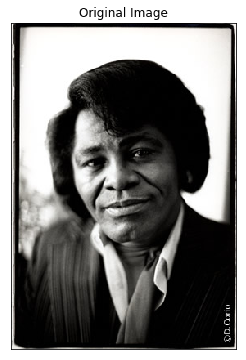

In [50]:
# Load in color image for face detection
image = cv2.imread('images/james.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Notice that even though the image is an original black and white image, we *have to read it in* as a color image that will still need to be converted to grayscale in order to perform the accurate face detection.

So, let's convert this image to grayscale, then load OpenCV's face detector and run it with parameters that detect this face accurately. 

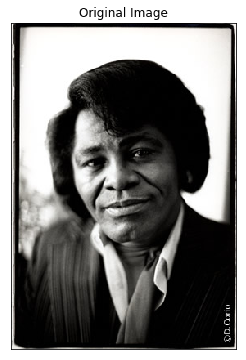

In [7]:
# Convert the image to Gray color space
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Plot the RGB image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

Number of faces detected: 1


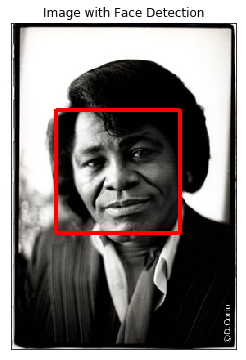

In [8]:
# Extract the pre-trained face detector from an xml file
# This feature still uses frontal face detection
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray, 1.25, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face Detection')
ax1.imshow(image_with_detections)

### Add an eye detector to the current face detection setup.  

let's build a Haar-cascade eye detector that can be included in the same way that the face detector was!

To set up an eye detector, we use the stored parameters of the eye cascade detector, called ```haarcascade_eye.xml```, located in the `detector_architectures` subdirectory. Things to note:

* First, let's make sure to give our loaded eye detector the variable name (``eye_cascade``). We give the list of eye regions you detect the variable name (``eyes``).

* Second, since we've already run the face detector over this image, we should only search for eyes *within the rectangular face regions detected in ``faces``* (overlay classifiers!) This will minimize false detections, since there's a way to pre test it!

Lastly, once you've run your eye detector over the facial detection region, you should display the RGB image with both the face detection boxes (in red) and your eye detections (in green) to verify that everything works as expected.

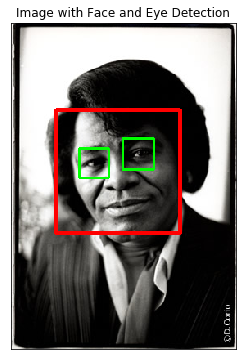

In [9]:
# Make a copy of the original image to plot rectangle detections
image_with_detections = np.copy(image)   

# Loop over the detections and draw their corresponding face detection boxes
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(255,0,0), 3)  
    
# Do not change the code above this comment!

    
## Add eye detection, using haarcascade_eye.xml, to the current face detector algorithm
# Build on the existing cv2 object
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')
eyes = eye_cascade.detectMultiScale(image_with_detections, 1.05, 4)

## Loop over the eye detections and draw their corresponding boxes in green on image_with_detections
for (x,y,w,h) in eyes:
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h),(0,255,0), 2)

# Plot the image with both faces and eyes detected
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with Face and Eye Detection')
ax1.imshow(image_with_detections)

In [11]:
# Call the laptop camera face/eye detector function above
# laptop_camera_go()

---
<a id='step2'></a>

## Step 2: De-noise an Image for Better Face Detection

Image quality is an important aspect of any computer vision task. 

Typically, when creating a set of images to train a deep learning network, significant care is taken to ensure that training images are free of visual noise or artifacts that hinder object detection.  While computer vision algorithms - like a face detector - are typically trained on 'nice' data such as this, **new test data doesn't always look so nice!**

### Pre Processing 
When applying a trained computer vision algorithm to a new piece of test data one often cleans it up first before feeding it in.

This sort of cleaning - referred to as *pre-processing* - can include a number of cleaning phases like blurring, de-noising, color transformations, etc., and many of these tasks can be accomplished using OpenCV.

In this short subsection we explore OpenCV's noise-removal functionality to see how we can clean up a noisy image, which we then feed into our trained face detector!

### Create a noisy image to work with

In the next cell, we create an artificial noisy version of the previous multi-face image.  This is a little exaggerated - we don't typically get images that are this noisy - but [image noise](https://digital-photography-school.com/how-to-avoid-and-reduce-noise-in-your-images/), or 'grainy-ness' in a digitial image - is a fairly common phenomenon.

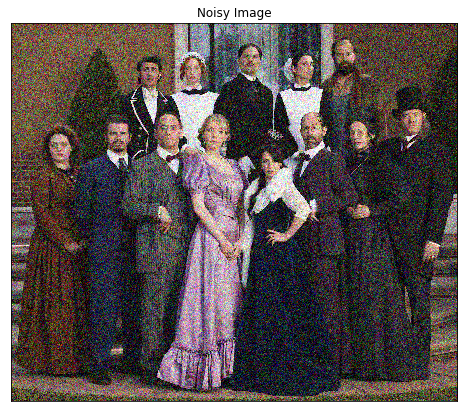

In [12]:
# Load in the multi-face test image again
image = cv2.imread('images/test_image_1.jpg')

# Convert the image copy to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Make an array copy of this image
image_with_noise = np.asarray(image)

# Create noise - here we add noise sampled randomly from a Gaussian distribution: a common model for noise
noise_level = 40
noise = np.random.randn(image.shape[0],image.shape[1],image.shape[2])*noise_level

# Add this noise to the array image copy
image_with_noise = image_with_noise + noise

# Convert back to uint8 format
image_with_noise = np.asarray([np.uint8(np.clip(i,0,255)) for i in image_with_noise])

# Plot our noisy image!
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image')
ax1.imshow(image_with_noise)

In the context of face detection, the problem with an image like this is that  - due to noise - we may miss some faces or get false detections. 

In the next cell we apply the same trained OpenCV detector with the same settings as before. Let's see what sort of detections we get!

Number of faces detected: 12


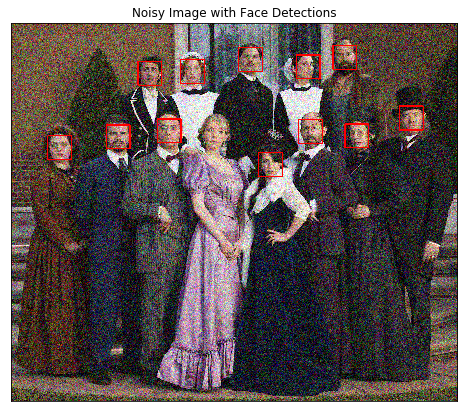

In [13]:
# Convert the RGB  image to grayscale
gray_noise = cv2.cvtColor(image_with_noise, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_noise, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
image_with_detections = np.copy(image_with_noise)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    

# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Noisy Image with Face Detections')
ax1.imshow(image_with_detections)

With this added noise we now miss one of the faces we had before!

Let's build in a pre-processing step to ensure we don't have this issue.

### De-noise this image for better face detection

Time to get our hands dirty: using OpenCV's built in color image de-noising functionality called ```fastNlMeansDenoisingColored()```, let's de-noise this image enough so that all the faces in the image are properly detected, and we can run it through our trained face detector.
 
 
What is **noise**? Noise is the arbitrary error of measurement. Using that notion, we can construct is a stochastic function, typically a random, normally distributed variable with zero mean. 

For images, consider a noisy pixel, p = p_0 + n where p_0 is the true value of pixel and n is the noise in that pixel. You can take large number of same pixels (say N) from different images and computes their average. Ideally, you should get p = p_0, since mean of noise is zero, and over multiple samples the noisiness should cancel itself out


You can find its [official documentation here]([documentation for denoising](http://docs.opencv.org/trunk/d1/d79/group__photo__denoise.html#ga21abc1c8b0e15f78cd3eff672cb6c476) and [a useful example here](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html), but here's the short version of what's happening:

![](http://opencv-python-tutroals.readthedocs.io/en/latest/_images/nlm_patch.jpg)

> The blue patches in the image looks the similar. Green patches looks similar. So we take a pixel, take small window around it, search for similar windows in the image, average all the windows and replace the pixel with the result we got. This method is Non-Local Means Denoising. It takes more time compared to blurring techniques we saw earlier, but its result is very good. More [details and online demo can be found at first link in additional resources.](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html)

**Note:** you can keep all parameters *except* `photo_render` fixed as shown in the second link above.  Play around with the value of this parameter - see how it affects the resulting cleaned image.

In [14]:
# %timeit!
## Use OpenCV's built in color image de-noising function to clean up our noisy image!

# fastNlMeansDenoisingColored(src[, dst[, h[, hColor[, templateWindowSize[, searchWindowSize]]]]])
denoised_image = cv2.fastNlMeansDenoisingColored(image_with_noise,None,19,19,7,21)

A notably expensive algorithm, but since it's using k-means clustering to generate consistent structure from noisy little windows, maybe it'll get our face detection back!

Number of faces detected: 13


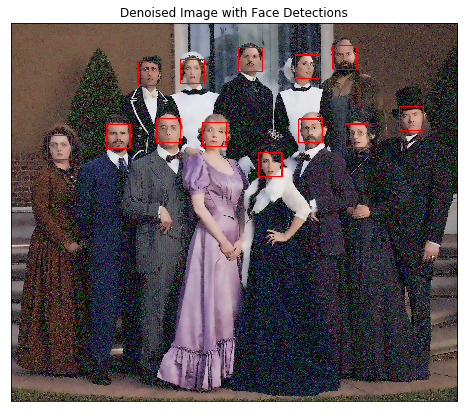

In [15]:
# Convert the RGB  image to grayscale
gray_denoise = cv2.cvtColor(denoised_image, cv2.COLOR_RGB2GRAY)

# Extract the pre-trained face detector from an xml file
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image
faces = face_cascade.detectMultiScale(gray_denoise, 4, 6)

# Print the number of faces detected in the image
print('Number of faces detected:', len(faces))

# Make a copy of the orginal image to draw face detections on
denoised_image_with_detections = np.copy(denoised_image)

# Get the bounding box for each detected face
for (x,y,w,h) in faces:
    # Add a red bounding box to the detections image
    cv2.rectangle(denoised_image_with_detections, (x,y), (x+w,y+h), (255,0,0), 3)
    
# Display the image with the detections
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Denoised Image with Face Detections')
ax1.imshow(denoised_image_with_detections)

---
<a id='step3'></a>

## Step 3: Blur an Image and Perform Edge Detection

Now that we have developed a simple pipeline for detecting faces using OpenCV - let's start playing around with a few fun things we can do with all those detected faces!

### Importance of Blur in Edge Detection

Edge detection is a concept that pops up almost everywhere in computer vision applications, as edge-based features (as well as features built on top of edges) are often some of the best features for e.g., object detection and recognition problems.

Edge detection is a *dimension reduction* technique - by keeping only the edges of an image we get to throw away a lot of non-discriminating information!   This way, we only preserve the most important, global structures (ignoring local structures that aren't very discriminative). 

As you can imagine, removing irrelevent local structures is a crucial pre-processing step to performing edge detection in an image, and it turns out **blurring** can do just that!

Below is an animated gif showing the result of an edge-detected cat [taken from Wikipedia](https://en.wikipedia.org/wiki/Gaussian_blur#Common_uses), where the image is gradually blurred more and more prior to edge detection. 

<img src="images/Edge_Image.gif" width=400 height=300/>

When the animation begins you can't quite make out what it's a picture of, but as the animation evolves **local structures are removed via blurring the cat becomes visible in the edge-detected image.**

Edge detection is a **convolution** performed on the image itself, and you can read about Canny edge detection on [this OpenCV documentation page](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html).

### Canny edge detection

In the cell below we load in a test image, then apply *Canny edge detection* on it. The original image is on the left, and the edge-detected version is on the right. 

Notice how the result looks very busy - there are too many little details preserved in the image before it is sent to the edge detector! 

When applied in computer vision applications, edge detection should preserve *global* structure; doing away with local structures that don't help describe what objects are in the image.

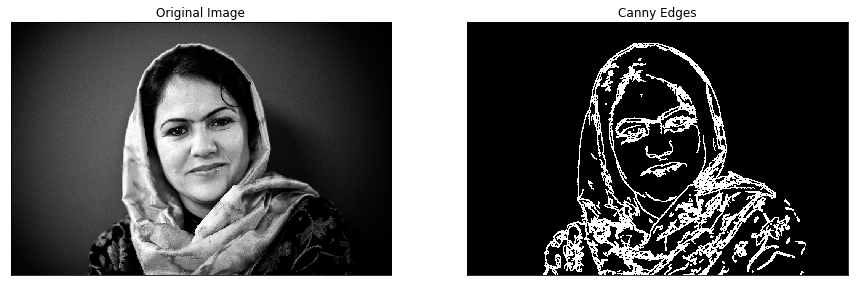

In [16]:
# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Perform Canny edge detection
edges = cv2.Canny(gray,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

Without first blurring the image, and removing small, local structures, a lot of irrelevant edge content gets picked up and amplified by the detector (as shown in the right panel above). 

### Blur the image *then* perform edge detection

So, instead of all these fine details, lets blur our image and figure out we're *generally* looking at, i.e. dropping local noise for global structure!


In the next cell, we will repeat this experiment - blurring the image first to remove these local structures, so that only the important boudnary details remain in the edge-detected image.

Lets blur the image by using OpenCV's ```filter2d()``` functionality - which is discussed in [this documentation page](http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html) - and use an *averaging kernel* of width equal to 4.

So what's going on within the function? In general, convolution is an operation between every part of an image and an operator (kernel); using linear algebra to transform image matrices!

A **kernel is essentially a fixed size array of numerical coefficeints along with an anchor point in that array, which is tipically located at the center.**

![](https://docs.opencv.org/2.4/_images/filter_2d_tutorial_kernel_theory.png)

Therefore, the value of a convolution is calculated in the following way:

1) Place the kernel anchor on top of a determined pixel, with the rest of the kernel overlaying the corresponding local pixels in the image.
2) Multiply the kernel coefficients by the corresponding image pixel values and sum the result.
3) Place the result to the location of the anchor in the input image.
4) Repeat for all pixels by scanning the kernel over the entire image.

Expressing the procedure above in the form of an equation we would have:

$ H(x,y) = \sum_{i=0}^{M_{i} - 1} \sum_{j=0}^{M_{j}-1} I(x+i - a_{i}, y + j - a_{j})K(i,j) $

Fortunately, [OpenCV](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/filter_2d/filter_2d.html) provides you with the function ```filter2D()``` so you do not have to code all these operations!

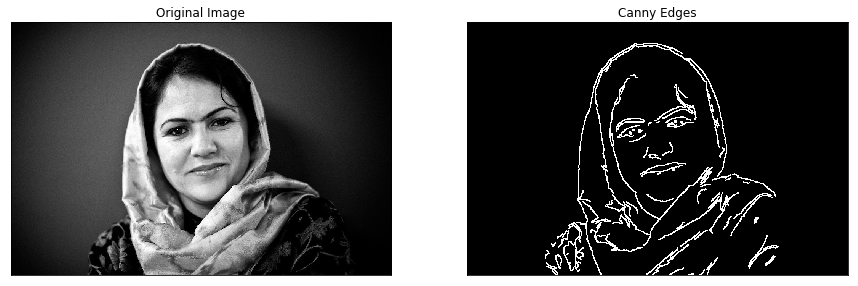

In [17]:
### Blur the test imageusing OpenCV's filter2d functionality, 

# Load in the image
image = cv2.imread('images/fawzia.jpg')

# Convert to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  

# Use an averaging kernel, and a kernel width equal to 4
kernel = np.ones((4,4),np.float32)/16
blurred = cv2.filter2D(gray,-1,kernel)
    
# Perform Canny edge detection
edges = cv2.Canny(blurred,100,200)

# Dilate the image to amplify edges
edges = cv2.dilate(edges, None)

# Plot the RGB and edge-detected image
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

ax2 = fig.add_subplot(122)
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_title('Canny Edges')
ax2.imshow(edges, cmap='gray')

---
<a id='step4'></a>

## Step 4: Automatically Hide the Identity of an Individual

For a documentary or reality TV, we often must get permission from every individual shown on film before you can show their face, **otherwise you need to blur it out - by blurring the face a lot**. Let's figure out how!

This is also true for projects like [Google's StreetView maps](https://www.google.com/streetview/) - an enormous collection of mapping images taken from a fleet of Google vehicles; **because it would be impossible for Google to get the permission of every single person accidentally captured in one of these images they blur out everyone's faces, the detected images must automatically blur the identity of detected people.**  Here's a few examples of folks caught in the camera of a Google street view vehicle:

<img src="images/streetview_example_1.jpg" width=400 height=300/>
<img src="images/streetview_example_2.jpg" width=400 height=300/>


### Read in an image to perform identity detection

Let's try this out for ourselves.  Use the face detection pipeline built above and what you know about using the ```filter2D``` to blur and image, and use these in tandem to hide the identity of the person in the following image - loaded in and printed in the next cell. 

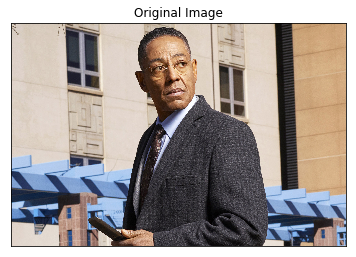

In [41]:
# Load in the image
image = cv2.imread('images/gus.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

### Use blurring to hide the identity of an individual in an image

Let's identify a face, then blur it out!

Our code should: 

1) Automatically detect the face in this image (we've got this bit)

2) Blur it out! 

Make sure to adjust the parameters of the *averaging* blur filter to completely obscure this person's identity.

[[0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]
 [0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]
 [0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]
 ...
 [0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]
 [0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]
 [0.00015625 0.00015625 0.00015625 ... 0.00015625 0.00015625 0.00015625]]


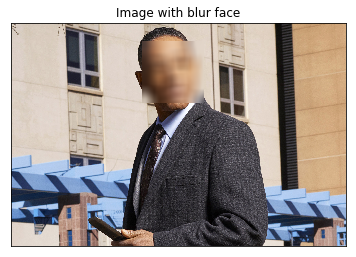

In [44]:
#Copy image
image_with_blur_face = np.copy(image)

#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# Detect the faces in image using the Haar Caascade classifier
faces = face_cascade.detectMultiScale(gray, 1.13, 6)

# Using averaging blur filter, with a big ol' scaled kernel of 1s
# Make all these values tend to 1 
kernel = np.ones((80, 80),np.float32) / 6400
print(kernel)    

## Blur the bounding box around each detected face using an averaging filter and display the result
for (x,y,w,h) in faces:
    # Too small - filtering mistakes; scale up!
    if(w < 100) | (h < 100):
        continue  
    # Blur bounding box to the detections image
    image_with_blur_face[y:y+h, x:x+w] = cv2.filter2D(image_with_blur_face[y:y+h, x:x+w], -1, kernel)
  
# Display the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Image with blur face')
ax1.imshow(image_with_blur_face)

---
<a id='step5'></a>

## Step 5: Create a CNN to Recognize Facial Keypoints

Alright, we're ready to recognize faces!

In practice, the [OpenCV Library](https://opencv.org/) is often used with other machine learning and deep learning libraries to produce interesting results.

In this stage of the project we will create our own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

We will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  Then, we'll use OpenCV to expand our detection algorithm to more general images. 

First things first, What are **facial keypoints**?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc. 

Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

![](https://www.yourtango.com/sites/default/files/snap1.gif)

Below we illustrate a filter that, using the results of this section, automatically places sunglasses on people in images (using the facial keypoints to place the glasses correctly on each face). Here, the facial keypoints have been colored lime green for visualization purposes:

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

### Make a facial keypoint detector

So, how can we make a facial keypoint detector?  

Well, at a high level, notice that facial keypoint detection is a *regression problem*: A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point). 

Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data).


![](https://kaggle2.blob.core.windows.net/competitions/kaggle/3486/logos/front_page.png)

We've already downloaded this data and placed it in the `data` directory. Make sure that you have both the *training* and *test* data files! 

The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand (!), and recorded in $(x, y)$ coordinates. 

This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network!


### Load Data
To load in this data, run the Python cell below - notice we will load in both the training and testing sets.

The `load_data()` function is in the included in the handy `utils.py` file.

In [22]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

/Users/vivek.menon/.anaconda/envs/aind-cv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


The `load_data()` function in `utils.py` originates from this excellent [blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), which you are *strongly* encouraged to read.



In [23]:
def load_data(test=False):
    """
    Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Important that the files are in a `data` directory
    """  
    FTRAIN = 'data/training.csv'
    FTEST = 'data/test.csv'
    
    # Testing data or training data?
    fname = FTEST if test else FTRAIN
    
    # Read it's csv into a pandas DataFrame
    df = read_csv(os.path.expanduser(fname))  

    # The Image column has pixel values separated by space; convert to numpy array:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # Drop all rows that have missing values in them
    df = df.dropna()  
    
    # Normalize pixel values to [0, 1] via scaling
    X = np.vstack(df['Image'].values) / 255.  
    X = X.astype(np.float32)
    
    # Reshape back into images as 96 x 96 x 1
    X = X.reshape(-1, 96, 96, 1) 
    
    # only FTRAIN has target columns
    if not test:  
        y = df[df.columns[:-1]].values         # target coordinates 
        y = (y - 48) / 48                      # scale to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)               # return as float32
    else:
        y = None

    return X, y

Note how the output values - that is, the coordinates of each set of facial landmarks - have been normalized to take on values in the range $[-1, 1]$, while the pixel values of each input point (a facial image) have been normalized to the range $[0,1]$. 

Note: the original Kaggle dataset contains some images with several missing keypoints.  For simplicity, the `load_data()` function removes those images with missing labels from the dataset.  As an __*optional*__ extension, you are welcome to amend the `load_data` function to include the incomplete data points!

### Visualize the Training Data

Execute the code cell below to visualize a subset of the training data.

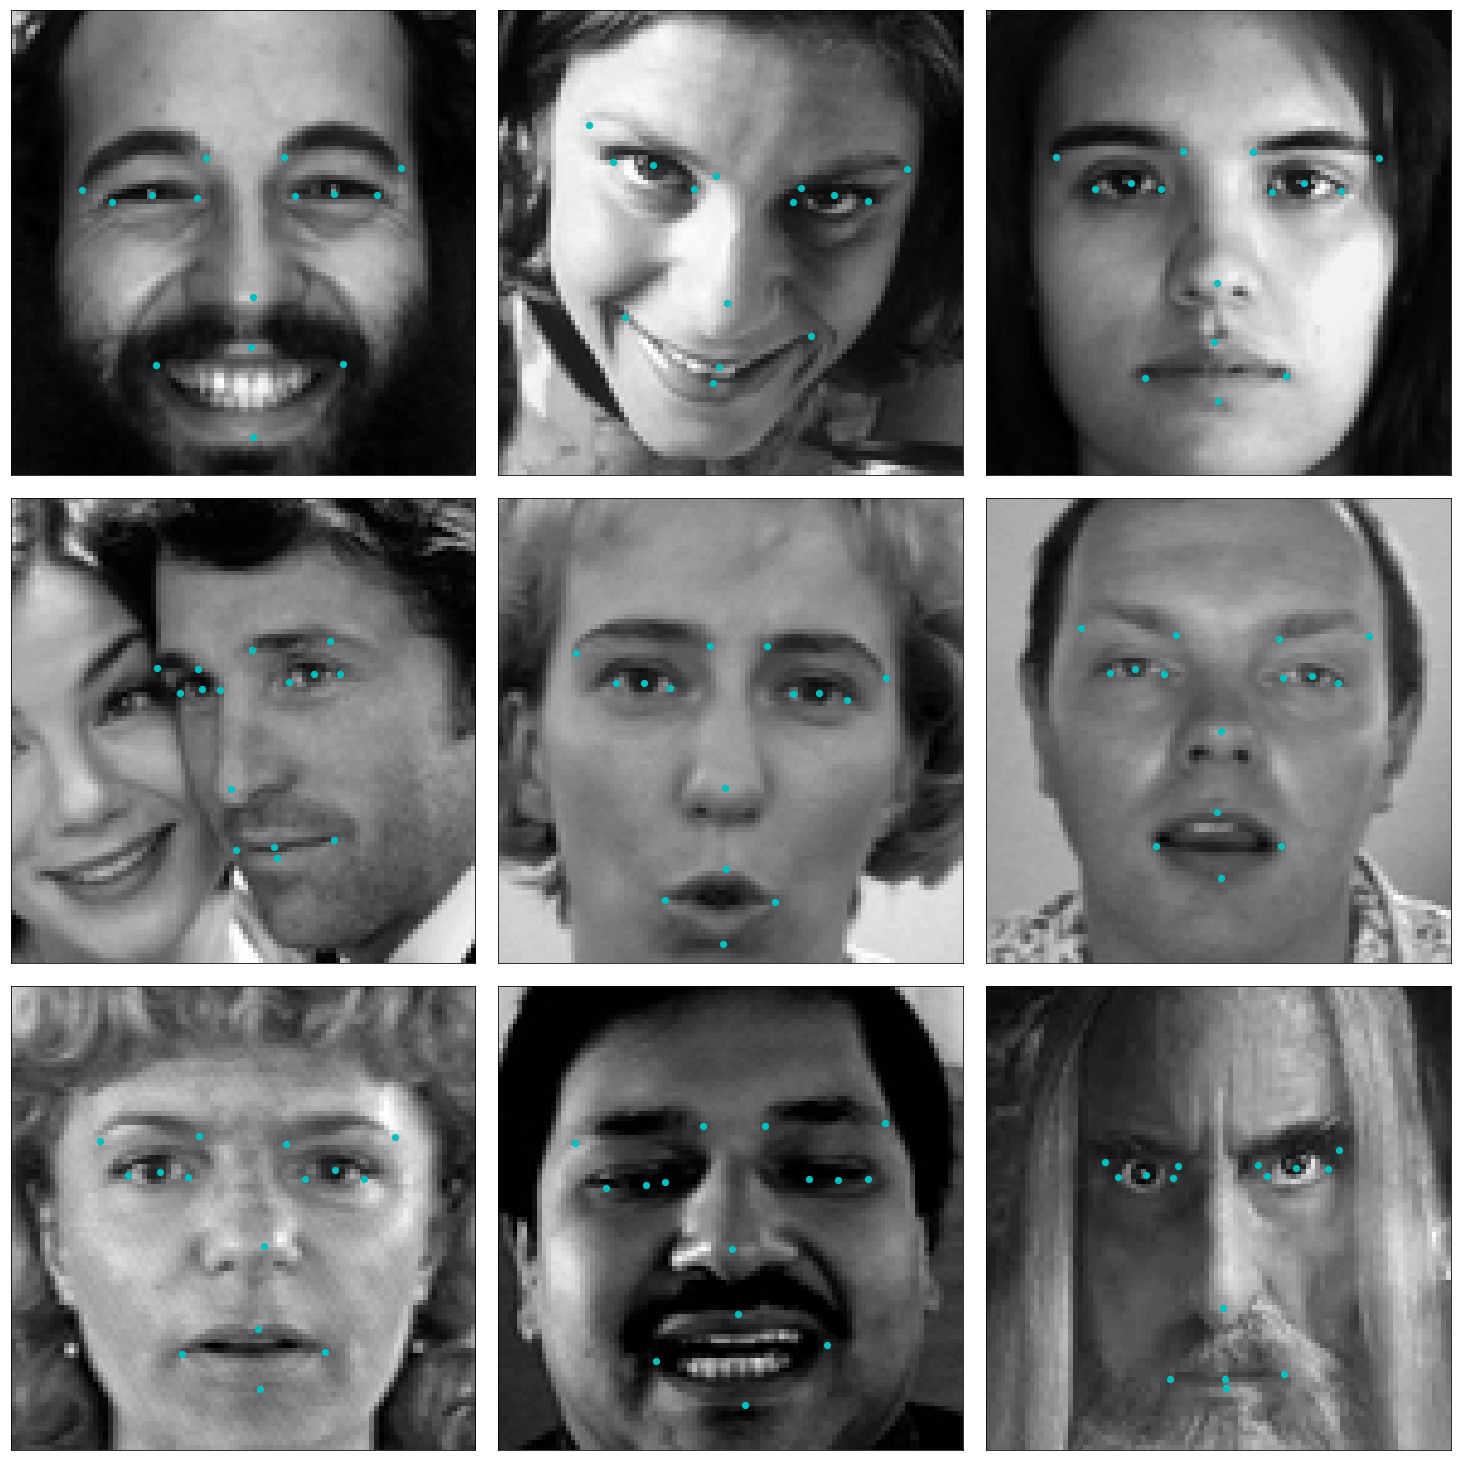

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

For each training image, there are:
* **2** landmarks per eyebrow (**4** total).
* **3** per eye (**6** total).
* **4** for the mouth.
* **1** for the tip of the nose.  

Review the `plot_data()` function in `utils.py` to understand how the 30-dimensional training labels in `y_train` are mapped to facial locations, as this function will prove useful for your pipeline!

In [25]:
def plot_data(img, landmarks, axis):
    """
    Plot image (img), along with normalized facial keypoints (landmarks)
    """
    # plot the image
    axis.imshow(np.squeeze(img), cmap='gray') 
    
    # undo the normalization (!?)
    landmarks = landmarks * 48 + 48 
    
    # Plot the keypoints
    axis.scatter(landmarks[0::2], 
        landmarks[1::2], 
        marker='o', 
        c='c', 
        s=40)

### Specify the CNN Architecture

In this section, you will specify a neural network for predicting the locations of facial keypoints.  Use the code cell below to specify the architecture of your neural network.  We have imported some layers that you may find useful for this task, but if you need to use more Keras layers, feel free to import them in the cell.

Your network should accept a $96 \times 96$ grayscale image as input, and it should output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints.  If you are not sure where to start, you can find some useful starting architectures in [this blog](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), but you are not permitted to copy any of the architectures that you find online.

#### Intution

We are allowed to talk about [this awesome example though](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)! Let's see what's going on.

1) **Striding**: Stride controls how the kernel / filter moves around the input shape. It's basically the number of squares we can move by when we downsample; notice the output for a Stride of 1 vs. a Stride of 2:  (number of squares we can move by), 

![Stride 1](https://adeshpande3.github.io/assets/Stride1.png)
![Stride 2](https://adeshpande3.github.io/assets/Stride2.png)

2) **Padding**: As we can see, the output field for a larger stride is smaller the bigger we step; sooner or later, we'd have issues fitting our kernel onto the squashed images. That's where padding can help; if we set our padding to size 2, we add a little buffer room about the image that results in a (`36 x 36 x 2`) shape throughought our network, even while we downsample!

![Padding](https://adeshpande3.github.io/assets/Pad.png)

3) **Convolution**: Therefore, we can describe this convolutional layer in a mathematical space. Let's use `O` is the output height/length, `W` is the input height/length, `K` is the filter size, `P` is the padding, and `S` is the stride: 

![](https://adeshpande3.github.io/assets/Output.png)


4) **Activation**: Researchers like [Dr. Hinton](http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf) have discovered out that ReLU layers work far better then most other activators, especially with achieving computational efficiency without making a significant difference to the accuracy. It also helps to alleviate the vanishing gradient problem, which is the issue where the lower layers of the network train very slowly because the gradient decreases [exponentially through the layers](https://www.quora.com/What-is-the-vanishing-gradient-problem). ReLU activation just applies the function $f(x) = max(0, x)$ to all of the values in the input volume, so we get 0, an absolute integer, and no negatives.

![](http://i2.wp.com/www.jessicayung.com/wp-content/uploads/2017/05/cnn-fletcher-bach.gif?resize=720%2C530)

5) **Pooling**: Downsampling post activation! Unlike a typical convolution, we are picking standard 'pool' sizes with matching strides and padding, and will **not be generating any trainable parameters** that can be affected via ReLU activators and backpropogation. All we're getting a smaller / zoomed in image to work with; and feed into the next step!

![](https://adeshpande3.github.io/assets/MaxPool.png)

As we convolve, pool, dropout, and repeat, we can train our net to recognize the features we're looking for; and **where to put facial keypoints!** Later, we'll even compare our performance using the Haar Caascade classifier (and smush 'em together!) 

In [26]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, Dense

## A Convolutional Neural Network that:
# * Accept 96x96 pixel graysale images as input.
# * Use a fully-connected convolutional neural network to classify facial features.
# * Output a classification for 30 values (2 for each facial keypoint)


model = Sequential()                                    # A Linear CNN Layer Stack
model.add(Convolution2D(filters=32,     
                        kernel_size=3, 
                        padding='valid', 
                        activation='relu', 
                        input_shape=X_train.shape[1:])) # Layer 1: 2D Convolution,
                                                        # 32 Filters (independent kernels)
                                                        # Using a 3x3 Kernel for the operation,
                                                        # 'Same' style padding for uniform image size
                                                        # Rectified Linear Unit activation,
                                                        # Shape is the input layer, so use first sample shape
                    
model.add(MaxPooling2D(pool_size=2))                    # Layer 2: Pooling
                                                        # Pool / Average input using 2x2 kernel
                                                        # Reduce size of kernel (and resulting computation)
                                                        # Let's use increase filters and avoid overfitting
            
model.add(Dropout(0.2))                                 # Layer 3: Dropout
                                                        # Drop paramaters to avoid overfitting
                                                        # Somehow even improves performance. Dope.

model.add(Convolution2D(filters=64, 
                        kernel_size=2, 
                        padding='same', 
                        activation='relu'))             # Layer 4: 2D Convolution,
                                                        # 128 Filters at 2x2, same padding, ReLU activation

model.add(MaxPooling2D(pool_size=2))                    # Layer 5: Pooling 
                                                        # Pool / average input using 2x2 kernel
    
model.add(Dropout(0.2))                                 # Layer 6: Dropout
                                                        # Drop 20% of paramaters 
    
model.add(Convolution2D(filters=128,
                        kernel_size=2,
                         padding='same',
                         activation='relu'))            # Layer 7: 2D Convolution,
                                                        # 128 Filters at 2x2, same padding, ReLU activation
    
model.add(MaxPooling2D(pool_size=2))                    # Layer 8: Pooling 
                                                        # Pool / average input using 2x2 kernel
    
model.add(Dropout(0.2))                                 # Layer 9: Dropout
                                                        # Drop 20% of paramaters 
    
model.add(Convolution2D(filters=256,
                         kernel_size=2,
                         padding='same',
                         activation='relu'))            # Layer 10: 2D Convolution,
                                                        # 256 Filters at 2x2, same padding, ReLU activation
    
model.add(MaxPooling2D(pool_size=2))                    # Layer 11: Pooling 
                                                        # Pool / average input using 2x2 kernel
    
model.add(Dropout(0.2))                                 # Layer 12: Dropout
                                                        # Drop 20% of paramaters 
model.add(Convolution2D(filters=512,
                         kernel_size=2,
                         padding='same',
                         activation='relu'))            # Layer 13: 2D Convolution,
                                                        # 512 Filters! at 2x2, same padding, ReLU activation
    
model.add(MaxPooling2D(pool_size=2))                    # Layer 11: Pooling 
                                                        # Pool / average input using 2x2 kernel
    
model.add(Dropout(0.2))                                 # Layer 12: Dropout
                                                        # Drop 20% of paramaters 

model.add(GlobalAveragePooling2D())                     # Layer 13: Global 2D Pooling
                                                        # Global pooling to ensure structural regularization
                                                        # Evidently good for avoiding overfitting
        
model.add(Dense(30))                                    # Layer 14: Dense Layer
                                                        # Dense layer for 30 categories / 15 keypoint features

model.summary()                                         # Model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       32896     
__________

---
<a id='step6'></a>

## Step 6: Compile and Train the Model

After specifying your architecture, you'll need to compile and train the model to detect facial keypoints'

### Compile and Train the Model

Use the `compile()` [method](https://keras.io/models/sequential/#sequential-model-methods) to configure the learning process. Be sure to experiment with your choice of [optimizer](https://keras.io/optimizers/); you may have some ideas about which will work best (`SGD` vs. `RMSprop`, etc), but take the time to empirically verify your theories.

Use the `fit()` [method](https://keras.io/models/sequential/#sequential-model-methods) to train the model.  Break off a validation set by setting `validation_split=0.2`.  Save the returned `History` object in the `history` variable.  

Experiment with your model to minimize the validation loss (measured as mean squared error). A very good model will achieve about 0.0015 loss (though it's possible to do even better).  When you have finished training, [save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) as an HDF5 file with file path `my_model.h5`.

In [27]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import ModelCheckpoint 

## Compile the model
model.compile(optimizer='Adamax', loss="mean_squared_error", metrics=['accuracy'])

## Save the best model as model.h5 (!)
checkpointer = ModelCheckpoint(filepath='my_model.h5', 
                               verbose=1, save_best_only=True)

## Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=128, verbose=1, 
          validation_split=0.2, callbacks=[checkpointer])

Train on 1712 samples, validate on 428 samples
Epoch 1/128
1712/1712 [==============================] - 54s 32ms/step - loss: 0.0295 - acc: 0.5794 - val_loss: 0.0554 - val_acc: 0.6963
Epoch 2/128
1712/1712 [==============================] - 50s 29ms/step - loss: 0.0076 - acc: 0.6513 - val_loss: 0.0473 - val_acc: 0.6963
Epoch 3/128
1712/1712 [==============================] - 44s 26ms/step - loss: 0.0062 - acc: 0.6606 - val_loss: 0.0469 - val_acc: 0.6963
Epoch 4/128
1712/1712 [==============================] - 44s 25ms/step - loss: 0.0058 - acc: 0.6665 - val_loss: 0.0440 - val_acc: 0.6963
Epoch 5/128
1712/1712 [==============================] - 44s 26ms/step - loss: 0.0057 - acc: 0.6782 - val_loss: 0.0460 - val_acc: 0.6963
Epoch 6/128
1712/1712 [==============================] - 47s 27ms/step - loss: 0.0055 - acc: 0.6741 - val_loss: 0.0451 - val_acc: 0.6963
Epoch 7/128
1712/1712 [==============================] - 48s 28ms/step - loss: 0.0055 - acc: 0.6729 - val_loss: 0.0456 - val_acc: 0

Epoch 30/128
1712/1712 [==============================] - 47s 27ms/step - loss: 0.0042 - acc: 0.7114 - val_loss: 0.0203 - val_acc: 0.7033
Epoch 31/128
1712/1712 [==============================] - 46s 27ms/step - loss: 0.0041 - acc: 0.6963 - val_loss: 0.0172 - val_acc: 0.7079
Epoch 32/128
1712/1712 [==============================] - 50s 29ms/step - loss: 0.0039 - acc: 0.6887 - val_loss: 0.0155 - val_acc: 0.7033
Epoch 33/128
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0038 - acc: 0.6992 - val_loss: 0.0181 - val_acc: 0.6986
Epoch 34/128
1712/1712 [==============================] - 42s 25ms/step - loss: 0.0038 - acc: 0.7044 - val_loss: 0.0168 - val_acc: 0.7056
Epoch 35/128
1712/1712 [==============================] - 48s 28ms/step - loss: 0.0037 - acc: 0.6974 - val_loss: 0.0167 - val_acc: 0.7009
Epoch 36/128
1712/1712 [==============================] - 49s 29ms/step - loss: 0.0036 - acc: 0.6957 - val_loss: 0.0136 - val_acc: 0.7033
Epoch 37/128
1712/1712 [==========

Epoch 60/128
1712/1712 [==============================] - 49s 29ms/step - loss: 0.0021 - acc: 0.7284 - val_loss: 0.0035 - val_acc: 0.7196
Epoch 61/128
1712/1712 [==============================] - 52s 30ms/step - loss: 0.0020 - acc: 0.7442 - val_loss: 0.0030 - val_acc: 0.7360
Epoch 62/128
1712/1712 [==============================] - 42s 25ms/step - loss: 0.0020 - acc: 0.7371 - val_loss: 0.0025 - val_acc: 0.7407
Epoch 63/128
1712/1712 [==============================] - 41s 24ms/step - loss: 0.0019 - acc: 0.7401 - val_loss: 0.0028 - val_acc: 0.7290
Epoch 64/128
1712/1712 [==============================] - 43s 25ms/step - loss: 0.0019 - acc: 0.7447 - val_loss: 0.0030 - val_acc: 0.7430
Epoch 65/128
1712/1712 [==============================] - 46s 27ms/step - loss: 0.0019 - acc: 0.7488 - val_loss: 0.0030 - val_acc: 0.7664
Epoch 66/128
1712/1712 [==============================] - 45s 26ms/step - loss: 0.0019 - acc: 0.7424 - val_loss: 0.0022 - val_acc: 0.7477
Epoch 67/128
1712/1712 [==========

Epoch 90/128
1712/1712 [==============================] - 43s 25ms/step - loss: 0.0011 - acc: 0.7932 - val_loss: 0.0015 - val_acc: 0.7710
Epoch 91/128
1712/1712 [==============================] - 48s 28ms/step - loss: 0.0011 - acc: 0.7932 - val_loss: 0.0017 - val_acc: 0.7617
Epoch 92/128
1712/1712 [==============================] - 44s 26ms/step - loss: 0.0011 - acc: 0.7932 - val_loss: 0.0018 - val_acc: 0.7593
Epoch 93/128
1712/1712 [==============================] - 38s 22ms/step - loss: 0.0011 - acc: 0.8020 - val_loss: 0.0014 - val_acc: 0.7664
Epoch 94/128
1712/1712 [==============================] - 38s 22ms/step - loss: 0.0011 - acc: 0.8020 - val_loss: 0.0017 - val_acc: 0.7757
Epoch 95/128
1712/1712 [==============================] - 37s 22ms/step - loss: 0.0010 - acc: 0.7926 - val_loss: 0.0015 - val_acc: 0.7664
Epoch 96/128
1712/1712 [==============================] - 44s 26ms/step - loss: 9.9107e-04 - acc: 0.7944 - val_loss: 0.0015 - val_acc: 0.7734
Epoch 97/128
1712/1712 [======

1712/1712 [==============================] - 41s 24ms/step - loss: 7.1528e-04 - acc: 0.8294 - val_loss: 0.0015 - val_acc: 0.8037
Epoch 121/128
1712/1712 [==============================] - 40s 23ms/step - loss: 7.2128e-04 - acc: 0.8347 - val_loss: 0.0015 - val_acc: 0.7874
Epoch 122/128
1712/1712 [==============================] - 41s 24ms/step - loss: 7.0470e-04 - acc: 0.8277 - val_loss: 0.0013 - val_acc: 0.7944
Epoch 123/128
1712/1712 [==============================] - 45s 26ms/step - loss: 7.0304e-04 - acc: 0.8248 - val_loss: 0.0014 - val_acc: 0.7827
Epoch 124/128
1712/1712 [==============================] - 49s 29ms/step - loss: 6.8147e-04 - acc: 0.8353 - val_loss: 0.0014 - val_acc: 0.8037
Epoch 125/128
1712/1712 [==============================] - 42s 25ms/step - loss: 6.9174e-04 - acc: 0.8300 - val_loss: 0.0014 - val_acc: 0.8014
Epoch 126/128
1712/1712 [==============================] - 41s 24ms/step - loss: 6.7665e-04 - acc: 0.8382 - val_loss: 0.0012 - val_acc: 0.7967
Epoch 127/128

Quick reference point when you're attempting to run the code above; I had to leave this computer on for at least half a day to roll the loss and accuracy to these levels. I literally had to restart the kernel to get my mode!

The good news is the `save()` function in our epoch step ensures we always save the best available model. This is where stuff like TensorFlow and Keras really shine; multiple layers of well thought out abstractions (in an occasionally opinionated syntax.)

In [61]:
from keras.models import load_model

# Loading the best model found
model = load_model('my_model.h5')

---
<a id='step7'></a>

## Step 7: Visualize the Loss and Test Predictions

### Answer a few questions and visualize the loss

__Question 1:__ Outline the steps you took to get to your final neural network architecture and your reasoning at each step.

__Answer:__  This structure is a fairly standard CNN skeleton, lifted and retrofit from some earlier work. I'd like to discuss the `convolution(), pooling(), dropout()` substack, because it's role seems crucial to our performance and [explored much more thoroughly in this paper](http://arxiv.org/pdf/1312.4400.pdf)). To poorly snynthesize, I feel it to give us 4 things:
* **Scaling Filters**: Without pooling and dropout, the number of trainable parameters would get out of control too fast; we're already at 712K trainable values, and thats already with 20% decrease in connectivity every stage.
* **Kernel Pooling**: Reducing images to smaller, denser vectors seems counterintuitive, but the intuition seems very similar to the Gaussian blurring we used for edge detection earlier; by blurring or otherwise transforming a region, we drop local structure for global structures. 
* **Cascading Convolution**: Just like the earlier cascade filter, we are best served by analyzing the existence of 'feature groups', which is kind of what this CNN is stumbling upon, especially by using the well labelled keypoint data to correct via backprop. This idealogy has been further evolved using [Capsule Networks](https://medium.com/ai%C2%B3-theory-practice-business/understanding-hintons-capsule-networks-part-ii-how-capsules-work-153b6ade9f66) from the OG himself, [George Hinton](http://www.cs.toronto.edu/~hinton/).
* **Dropout**: Dropout is a remarkably useful tool for preventing overfitting. I have still to understand why fewer connections yield such better results, though a little noise seems to great improve the performance. For some reason or another, gradient descent goes smoother on slightly rougher, unknown terrain. 

After all those layers I we added a `globalaveragepool()` of [ResNet-50](https://keras.io/applications/#resnet50) fame. It aims to enforce global feature detection, further preventing overfitting, before a final `dense()` layer to classify our feature detection output via 30 densly connected linear classifiers. 


__Question 2:__ Defend your choice of optimizer.  Which optimizers did you test, and how did you determine which worked best?

__Answer:__ The [`Adamax`](https://arxiv.org/pdf/1412.6980.pdf) is an evolution of the `Adam` optimizer, which computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients; hence it's name, *Ada*ptive *M*oment estimation. It sounds like just bias-free `RMSProp` estimation, which is more cost effective. `Adamax` is a further expansion of the `Adam` optimizer, whose update rule for individual weights is to scale their gradients inversely proportional to a (scaled) $L^2$ norm of their current and past gradients. If we generalize this $L^2$ norm-based update rule to an $L^p$  norm based update rule, we run into variants that become numerically unstable for large $p$. However, a special case emerges for just the limit, i.e. $p → ∞$; a surprisingly simple and stable algorithm emerges! Frankly speaking, some of the math past this point is well beyond me, but as a new and interesting optimizer I was eager to test it in the field.

Use the code cell below to plot the training and validation loss of your neural network.  You may find [this resource](http://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) useful.

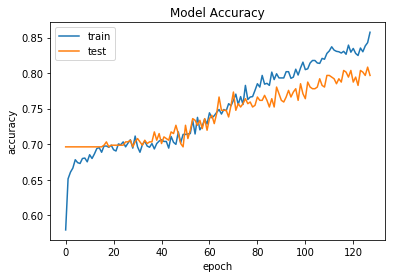

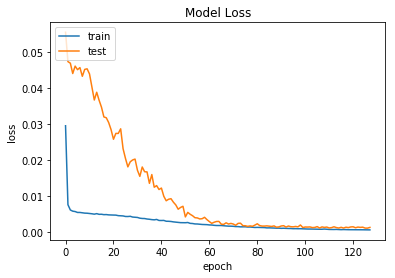

In [62]:
## Visualize the training and validation loss of your neural network 

# Available historical data
# print(hist.history.keys())

# Accuracy History
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss History
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?  If so, what steps have you taken to improve your model?  Note that slight overfitting or underfitting will not hurt your chances of a successful submission, as long as you have attempted some solutions towards improving your model (such as _regularization, dropout, increased/decreased number of layers, etc_).

__Answer:__
In past projects with fewer layers and no dropout, I'd achieve some pretty horific losses. I'd hope that the more conservative, `dropout()` intensive architecture with the new `Adamax` optimizer should yield much better results. I also saw an increase in performance when I used that sub-network 4 times instead of just 3. I'd be open to any suggestions! Also, earlier runs of the training had a very close train and test loss, but it seems here that were are beginning to overfit quite severely to our training data. At least we're only talking about loss around 0.0010. 

### Visualize a Subset of the Test Predictions

Execute the code cell below to visualize your model's predicted keypoints on a subset of the testing images.

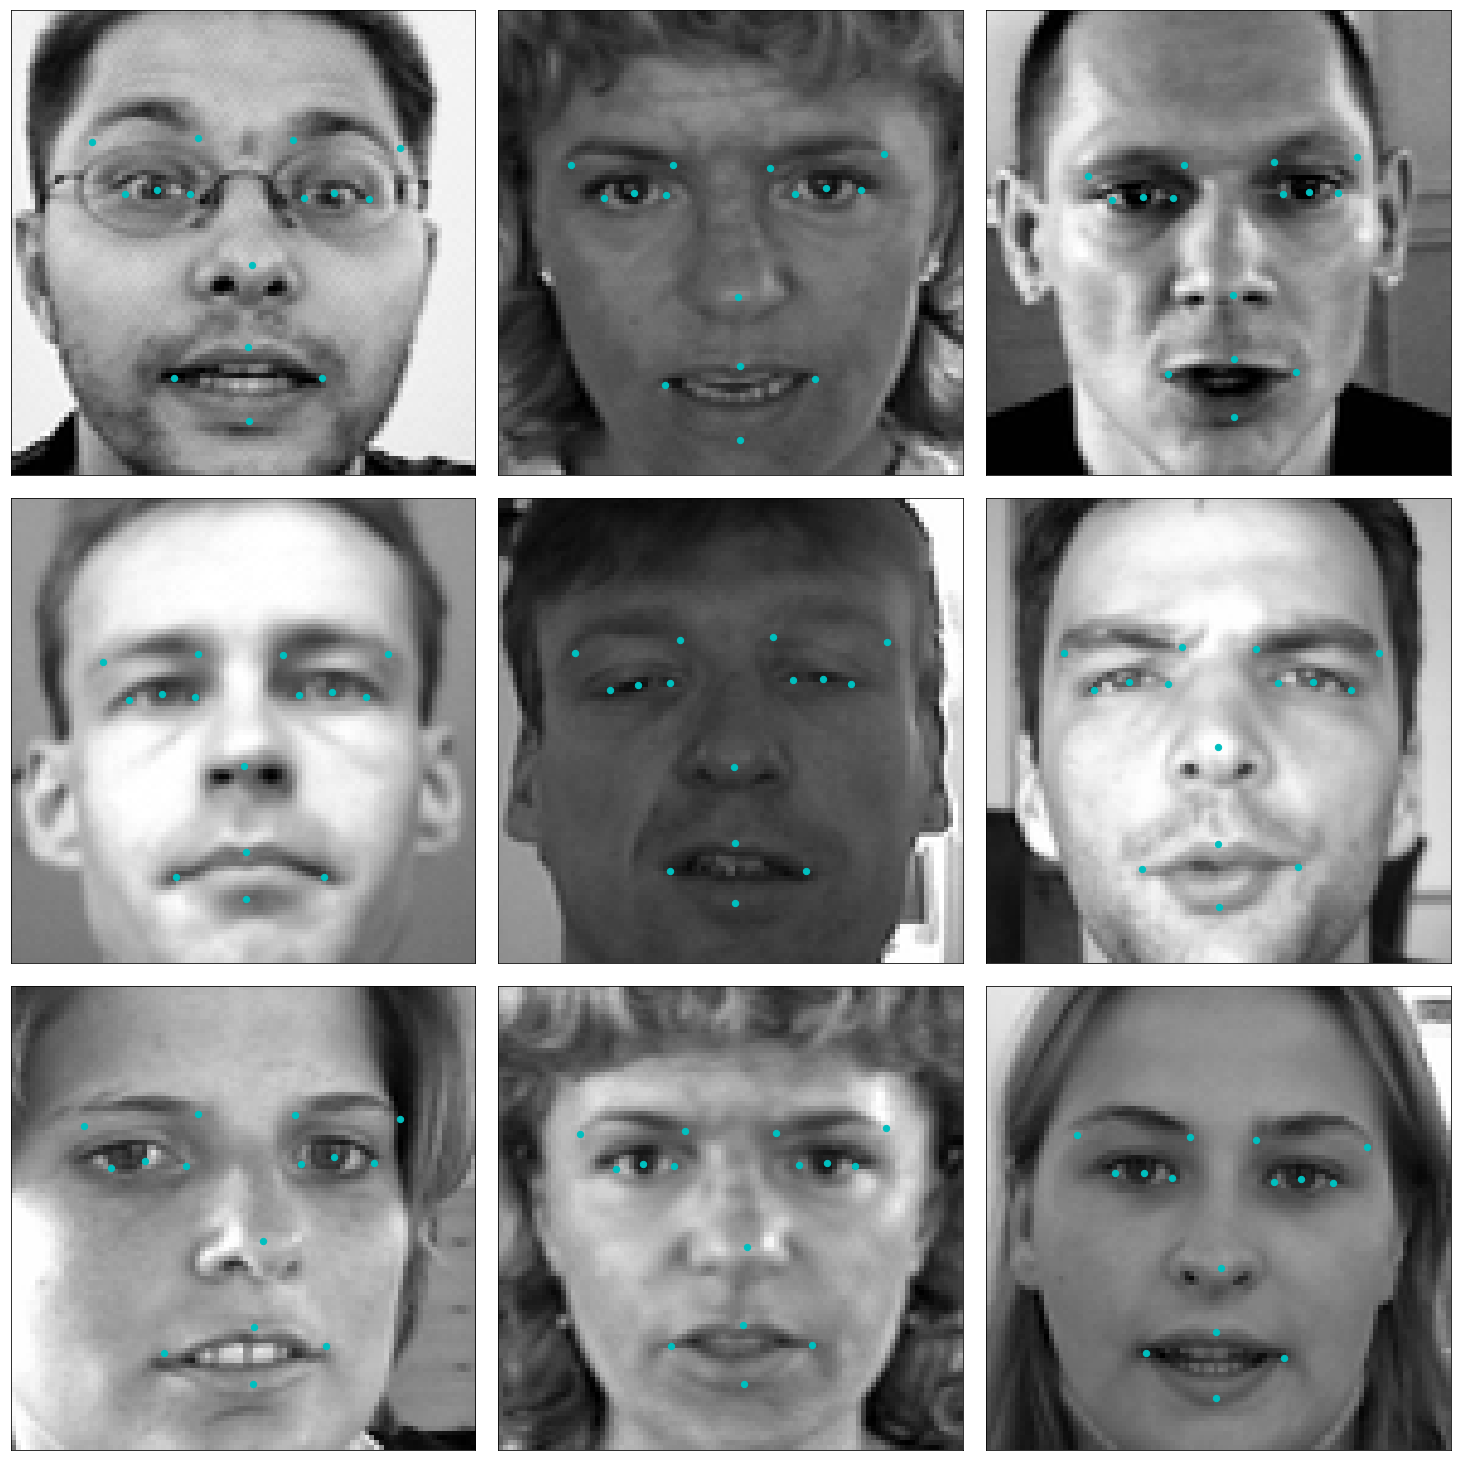

In [63]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)

---
<a id='step8'></a>

## Step 8: Complete the pipeline

With the work you did in Sections 1 and 2 of this notebook, along with your freshly trained facial keypoint detector, you can now complete the full pipeline.  That is given a color image containing a person or persons you can now 

- Detect the faces in this image automatically using OpenCV
- Predict the facial keypoints in each face detected in the image
- Paint predicted keypoints on each face detected

In this Subsection you will do just this!  

### Facial Keypoints Detector

Finally, let's use the OpenCV face detection functionality we built in previous Sections to expand the functionality of your keypoints detector to color images with arbitrary size. Our function should perform the following steps:

1. Accept a color image.
2. Convert the image to grayscale.
3. Detect and crop the face contained in the image.
4. Locate the facial keypoints in the cropped image.
5. Overlay the facial keypoints in the original (color, uncropped) image.

**Note**: step 4 can be the trickiest because remember your convolutional network is only trained to detect facial keypoints in $96 \times 96$ grayscale images where each pixel was normalized to lie in the interval $[0,1]$, and remember that each facial keypoint was normalized during training to the interval $[-1,1]$.  This means - practically speaking - to paint detected keypoints onto a test face you need to perform this same pre-processing to your candidate face  - that is after detecting it you should resize it to $96 \times 96$ and normalize its values before feeding it into your facial keypoint detector.  To be shown correctly on the original image the output keypoints from your detector then need to be shifted and re-normalized from the interval $[-1,1]$ to the width and height of your detected face.

When complete you should be able to produce example images like the one below

<img src="images/obamas_with_keypoints.png" width=1000 height=1000/>

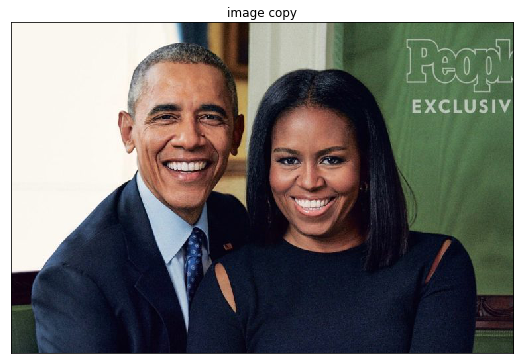

In [64]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')


# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# plot our image
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image copy')

ax1.imshow(image)

Number of faces detected: 2


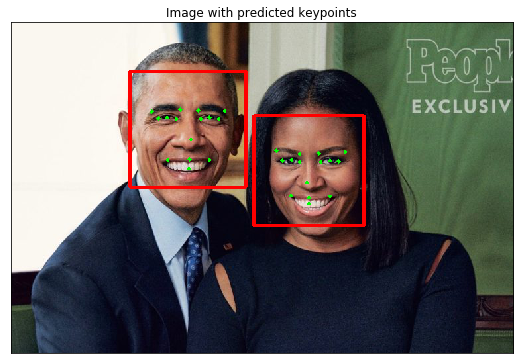

In [65]:
from keras.models import load_model
model = load_model('my_model.h5')

### Using the face detection code from Section 1 with our trained neural net:
## * Load the model using the best discovered weights (saved to my_model.h5).
## * Recognize faces, then predict where keypoints should go!
## * Paint those predicted keypoints on the test image!


def find_keypoints(image):
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, 1.25, 6)

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Make a copy of the orginal image to draw face detections on
    image_with_predicted_keypoints = np.copy(image)
    
    faces_keypoints = []
    
    for (x,y,w,h) in faces:
        
        # Crop and resize the face to 96 x 96 
        face_image = gray[y:y+h , x:x+w]
        resize_face = cv2.resize(face_image, (96, 96))

        # Normalize and convert to the input format
        normalized_face = resize_face / 255
        normalized_face = normalized_face[np.newaxis, :, :, np.newaxis]

        # Predict the face keypoints and un-normalized the coordinates
        keypoints = model.predict(normalized_face)
        
        # Just tried the voodoo from earlier; why is 48 (96/2) untransform the normalization?
        keypoints = keypoints * 48 + 48  

        # Convert keypoints to (x,y)
        x_coordinate, y_coordinate = keypoints[0][0::2], keypoints[0][1::2]
        
        # Scale x, y back up to  
        x_coordinate, y_coordinate = x + x_coordinate * w / 96, y + y_coordinate * h / 96
        
        # Use w, h to draw red boxes around the coordinates
        cv2.rectangle(image_with_predicted_keypoints, (x,y), (x+w,y+h), (255,0,0), 3)

        # Draw green circles around the keypoints!
        faces_keypoints.append((x_coordinate, y_coordinate))
    
        for xc, yc in zip(x_coordinate, y_coordinate):
            cv2.circle(image_with_predicted_keypoints, (xc, yc), 1, (0, 255, 0), 3)
             
    return image_with_predicted_keypoints, faces_keypoints

# Run Function
image_with_predicted_keypoints, faces_keypoints = find_keypoints(image)

# Display the image with the keypoints
fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Image with predicted keypoints')
ax1.imshow(image_with_predicted_keypoints)

That's it! Here's what we learnt: 

## Summary

**Part 1** : Investigating OpenCV, pre-processing, and face detection

* [Step 0](#step0): Detect Faces Using a Haar Cascade Classifier: Using a series of **pre-trained (cascading) classifiers** to identify edges and features in images. 
* [Step 1](#step1): Add Eye Detection: Updating the Classifier to **use a different set of feature weights, identifying new obejcts (faces AND eyes)**!
* [Step 2](#step2): De-noise an Image for Better Face Detection: Using the *expensive* [**Gaussian denoising algorithm**](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html)** to reduce the noise in image for better processing. 
* [Step 3](#step3): Blur an Image and Perform Edge Detection: Using the handy [**Canny Edge algorithm**](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html), blur input images into general structures; dropping local noise!
* [Step 4](#step4): Automatically Hide the Identity of an Individual: Blurring our detected faces by convolving our image with a large matrix of scaled ones, thereby averaging all of it together!

**Part 2** : Training a Convolutional Neural Network (CNN) to detect facial keypoints

* [Step 5](#step5): Create a CNN to Recognize Facial Keypoints: First, we use that [awesome dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data), and prep the data for use. 
* [Step 6](#step6): Compile and Train the Model: We build a CNN leading into a Classifier, and set it to try and tag the given facial detection points across a series of faces.
* [Step 7](#step7): Visualize the Loss and Answer Questions: Once we've hit very low loss (correct classifications) and improving accuracy (better, unbiased guess) 

**Part 3** : Putting parts 1 and 2 together to identify facial keypoints on any image!

* [Step 8](#step7): Build a Robust Facial Keypoints Detector (Complete the CV Pipeline): The magic of `model.predict()`. 

Good luck with your new face detector!

[![](https://static1.squarespace.com/static/574f0b9a37013b939ab0b866/t/5936b0e717bffc7a44df2ca0/1496756488470/)](http://cs231n.stanford.edu/)

### (Optional) Further Directions - add a filter using facial keypoints

Using your freshly minted facial keypoint detector pipeline you can now do things like add fun filters to a person's face automatically.  In this optional exercise you can play around with adding sunglasses automatically to each individual's face in an image as shown in a demonstration image below.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

To produce this effect an image of a pair of sunglasses shown in the Python cell below.

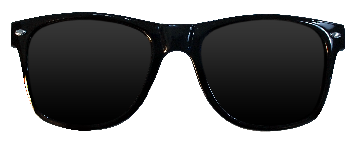

In [66]:
# Load in sunglasses image - note the usage of the special option
# cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
# image has a 4th channel that allows us to control how transparent each pixel in the image is
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(sunglasses)
ax1.axis('off');

This image is placed over each individual's face using the detected eye points to determine the location of the sunglasses, and eyebrow points to determine the size that the sunglasses should be for each person (one could also use the nose point to determine this).  

Notice that this image actually has *4 channels*, not just 3. 

In [67]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


It has the usual red, blue, and green channels any color image has, and a *4th channel representing the transparency level of each pixel in the image8.

Here's how the transparency channel works: the lower the value, the more transparent the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen. 

**This is how we can place this image of sunglasses on someone's face and still see the area around of their face where the sunglasses lie - because these extra pixels in the sunglasses image have been made completely transparent!**

Lets check out the alpha channel of our sunglasses image in the next Python cell.  Note because many of the pixels near the boundary are transparent we'll need to explicitly print out non-zero values if we want to see them. 

In [68]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('the alpha channel here looks like')
print (alpha_channel)

# Just to double check that there are indeed non-zero values
# Let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('\n the non-zero values of the alpha channel look like')
print (values)

the alpha channel here looks like
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 the non-zero values of the alpha channel look like
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter to tell us which pixels to overlay on a new image (only the non-transparent ones with values greater than zero).

One last thing: it's helpful to understand which keypoint belongs to the eyes, mouth, etc. So, in the image below, we also display the index of each facial keypoint directly on the image so that you can tell which keypoints are for the eyes, eyebrows, etc.

<img src="images/obamas_points_numbered.png" width=500 height=500/>

With this information, we're well on our way to completing this filtering task! Let's see if you can place the sunglasses automatically on the individuals in the image loaded in / shown in the next Python cell.

### (Optional) Further Directions - add a filter using facial keypoints

Using your freshly minted facial keypoint detector pipeline you can now do things like add fun filters to a person's face automatically.  In this optional exercise you can play around with adding sunglasses automatically to each individual's face in an image as shown in a demonstration image below.

<img src="images/obamas_with_shades.png" width=1000 height=1000/>

To produce this effect an image of a pair of sunglasses shown in the Python cell below.

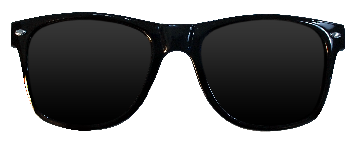

In [69]:
# Load in sunglasses image - note the usage of the special option
# cv2.IMREAD_UNCHANGED, this option is used because the sunglasses 
# image has a 4th channel that allows us to control how transparent each pixel in the image is
sunglasses = cv2.imread("images/sunglasses_4.png", cv2.IMREAD_UNCHANGED)

# Plot the image
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(sunglasses)
ax1.axis('off');

This image is placed over each individual's face using the detected eye points to determine the location of the sunglasses, and eyebrow points to determine the size that the sunglasses should be for each person (one could also use the nose point to determine this).  

Notice that this image actually has *4 channels*, not just 3. 

In [70]:
# Print out the shape of the sunglasses image
print ('The sunglasses image has shape: ' + str(np.shape(sunglasses)))

The sunglasses image has shape: (1123, 3064, 4)


It has the usual red, blue, and green channels any color image has, and a *4th channel representing the transparency level of each pixel in the image8.

Here's how the transparency channel works: the lower the value, the more transparent the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen. 

**This is how we can place this image of sunglasses on someone's face and still see the area around of their face where the sunglasses lie - because these extra pixels in the sunglasses image have been made completely transparent!**

Lets check out the alpha channel of our sunglasses image in the next Python cell.  Note because many of the pixels near the boundary are transparent we'll need to explicitly print out non-zero values if we want to see them. 

In [71]:
# Print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('the alpha channel here looks like')
print (alpha_channel)

# Just to double check that there are indeed non-zero values
# Let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('\n the non-zero values of the alpha channel look like')
print (values)

the alpha channel here looks like
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 the non-zero values of the alpha channel look like
(array([  17,   17,   17, ..., 1109, 1109, 1109]), array([ 687,  688,  689, ..., 2376, 2377, 2378]))


This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter to tell us which pixels to overlay on a new image (only the non-transparent ones with values greater than zero).

One last thing: it's helpful to understand which keypoint belongs to the eyes, mouth, etc. So, in the image below, we also display the index of each facial keypoint directly on the image so that you can tell which keypoints are for the eyes, eyebrows, etc.

<img src="images/obamas_points_numbered.png" width=500 height=500/>

With this information, we're well on our way to completing this filtering task! Let's see if you can place the sunglasses automatically on the individuals in the image loaded in / shown in the next Python cell.

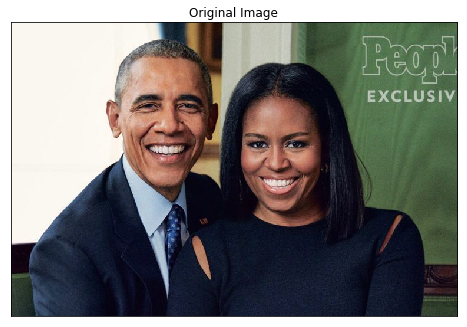

In [72]:
# Load in color image for face detection
image = cv2.imread('images/obamas4.jpg')

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Plot the image
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Original Image')
ax1.imshow(image)

In [73]:
## (Optional) Use the face detection code we saw in Section 1 with your trained conv-net to put
## sunglasses on the individuals in our test image

## Optional Animated Version!

Additional exercises to let your Laptop camera identify faces.

###  Further Directions - add a filter using facial keypoints to your laptop camera 

Now you can add the sunglasses filter to your laptop camera - as illustrated in the gif below.

<img src="images/mr_sunglasses.gif" width=250 height=250/>

The next Python cell contains the basic laptop video camera function used in the previous optional video exercises.  Combine it with the functionality you developed for adding sunglasses to someone's face in the previous optional exercise and you should be good to go!

### Add face and eye detection to your laptop camera

It's time to kick it up a notch, and add face and eye detection to your laptop's camera!  Afterwards, you'll be able to show off your creation like in the gif shown below - made with a completed version of the code!  

<img src="images/laptop_face_detector_example.gif" width=400 height=300/>

Notice that not all of the detections here are perfect - and your result need not be perfect either. You should spend a small amount of time tuning the parameters of your detectors to get reasonable results, but don't hold out for perfection.  If we wanted perfection we'd need to spend a ton of time tuning the parameters of each detector, cleaning up the input image frames, etc. You can think of this as more of a rapid prototype. 

The next cell contains code for a wrapper function called ``laptop_camera_face_eye_detector`` that, when called, will activate your laptop's camera.  You will place the relevant face and eye detection code in this wrapper function to implement face/eye detection and mark those detections on each image frame that your camera captures.

Before adding anything to the function, you can run it to get an idea of how it works - a small window should pop up showing you the live feed from your camera; you can press any key to close this window.

**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

In [74]:
### Add face and eye detection to this laptop camera function 
# Make sure to draw out all faces/eyes found in each frame on the shown video feed

import cv2
import time 

# wrapper function for face/eye detection with your laptop camera
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep the video stream open
    while rval:
        # Plot the image from camera with all the face and eye detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # Exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            # Make sure window closes on OSx
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    

In [75]:
import cv2
import time 
from keras.models import load_model
import numpy as np

def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    
        

In [76]:
# Load facial landmark detector model
# model = load_model('my_model.h5')

# Run sunglasses painter
# laptop_camera_go()

### (Optional) Build identity protection into your laptop camera

In this optional task you can add identity protection to your laptop camera, using the previously completed code where you added face detection to your laptop camera - and the task above.  You should be able to get reasonable results with little parameter tuning - like the one shown in the gif below.

<img src="images/laptop_blurer_example.gif" width=400 height=300/>

As with the previous video task, to make this perfect would require significant effort - so don't strive for perfection here, strive for reasonable quality.  

The next cell contains code a wrapper function called ``laptop_camera_identity_hider`` that - when called  - will activate your laptop's camera.  You need to place the relevant face detection and blurring code developed above in this function in order to blur faces entering your laptop camera's field of view.

Before adding anything to the function you can call it to get a hang of how it works - a small window will pop up showing you the live feed from your camera, you can press any key to close this window.

**Note:** Mac users may find that activating this function kills the kernel of their notebook every once in a while.  If this happens to you, just restart your notebook's kernel, activate cell(s) containing any crucial import statements, and you'll be good to go!

In [77]:
### Insert face detection and blurring code into the wrapper below to create an identity protector on your laptop!
import cv2
import time 

def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # Exit by pressing any key
            # Destroy windows
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()    
        

In [78]:
# Run laptop identity hider
#laptop_camera_go()

### (Optional) Further Directions - add a filter using facial keypoints to your laptop camera

Now you can add facial keypoint detection to your laptop camera - as illustrated in the gif below.

<img src="images/facial_keypoint_test.gif" width=400 height=300/>

The next Python cell contains the basic laptop video camera function used in the previous optional video exercises.  Combine it with the functionality you developed for keypoint detection and marking in the previous exercise and you should be good to go!

In [79]:
import cv2
import time 
from keras.models import load_model
def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # Try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # keep video stream open
    while rval:
        # plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # destroy windows
            cv2.destroyAllWindows()
            
            # hack from stack overflow for making sure window closes on osx --> https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()  

In [80]:
# Run your keypoint face painter
# laptop_camera_go()

In [81]:
## (Optional) Use the face detection code we saw in Section 1 with your trained conv-net to put
## sunglasses on the individuals in our test image

###  Further Directions - add a filter using facial keypoints to your laptop camera 

Now you can add the sunglasses filter to your laptop camera - as illustrated in the gif below.

<img src="images/mr_sunglasses.gif" width=250 height=250/>

The next Python cell contains the basic laptop video camera function used in the previous optional video exercises.  Combine it with the functionality you developed for adding sunglasses to someone's face in the previous optional exercise and you should be good to go!

In [82]:
import cv2
import time 
from keras.models import load_model
import numpy as np

def laptop_camera_go():
    # Create instance of video capturer
    cv2.namedWindow("face detection activated")
    vc = cv2.VideoCapture(0)

    # try to get the first frame
    if vc.isOpened(): 
        rval, frame = vc.read()
    else:
        rval = False
    
    # Keep video stream open
    while rval:
        # Plot image from camera with detections marked
        cv2.imshow("face detection activated", frame)
        
        # Exit functionality - press any key to exit laptop video
        key = cv2.waitKey(20)
        if key > 0: # exit by pressing any key
            # Destroy windows 
            cv2.destroyAllWindows()
            
            for i in range (1,5):
                cv2.waitKey(1)
            return
        
        # Read next frame
        time.sleep(0.05)             # control framerate for computation - default 20 frames per sec
        rval, frame = vc.read()

In [83]:
# Load facial landmark detector model
model = load_model('my_model.h5')

# Run sunglasses painter
# laptop_camera_go()